In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as plt

csv_files = [
    ('BTC-USD.csv', 'BTC'),
    ('BNB-USD.csv', 'BNB'),
    ('ETH-USD.csv', 'ETH'),
    ('SOL-USD.csv', 'SOL'),
    ('XRP-USD.csv', 'XRP'),
    ('EURUSD=X.csv', 'EUR'),
    ('NYA.csv', 'NYA'),
    ('CMX.csv', 'Gold'),
    ('SNP.csv', 'S&P 500'),
]

In [2]:
from utils.reader import CryptoCsvReader
from utils.plotter import Plotter

In [3]:
from scipy import stats as st
from utils.plotter import calculate_statistics

statistics = []

for path, name in csv_files:
    reader = CryptoCsvReader(f'data/{path}')
    data = reader.read()

    mean = np.mean(data)
    median = np.median(data)
    std_dev = np.std(data)
    kurtosis = st.kurtosis(data)
    skewness = st.skew(data)

    stats = pd.Series({
        'Mean': mean,
        'Median': median,
        'Standard Deviation': std_dev,
        'Kurtosis': kurtosis,
        'Skewness': skewness,
    })
    stats.name = name
    statistics.append(stats)

# Convert to DataFrame
stats_df = pd.DataFrame(statistics).T

# Rename index to match desired output
stats_df.to_csv('statistics_summary.csv', index=False)


# Save to CSV
stats_df.to_csv('statistics_summary.csv')



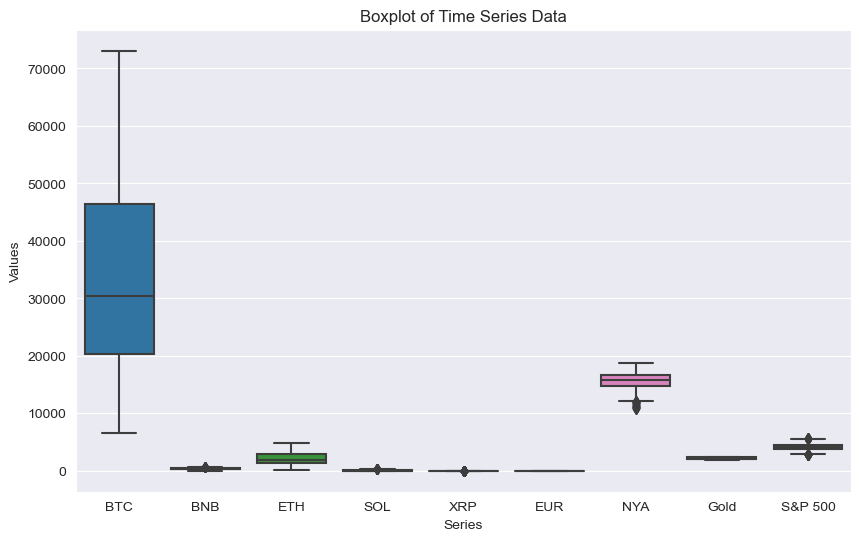

In [4]:
from matplotlib import pyplot as plt

time_series_list = []

for path, name in csv_files:
    data = pd.read_csv(f'data/{path}')
    data = data[['Close']].to_numpy()
    time_series_list.append((data, name))

time_series = [x[0] for x in time_series_list]
labels = [x[1] for x in time_series_list]
plt.figure(figsize=(10, 6))
sns.boxplot(data=time_series)
plt.xticks(range(len(labels)), labels)  # Set x-axis labels
plt.title('Boxplot of Time Series Data')
plt.xlabel('Series')
plt.ylabel('Values')
plt.savefig('imgs/boxplot.png')
plt.show() 

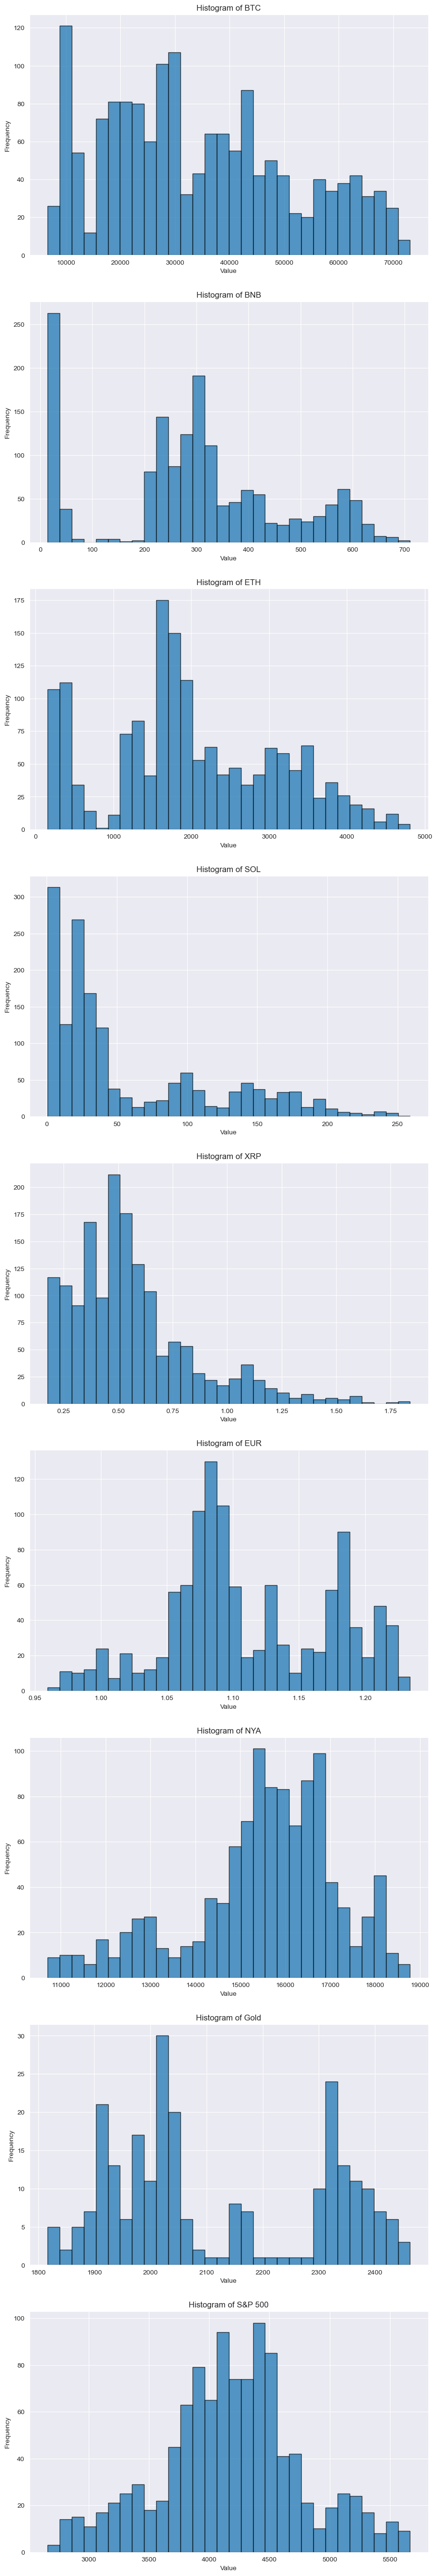

In [5]:
fig, axes = plt.subplots(nrows=len(time_series_list), ncols=1, figsize=(10, 6 * len(time_series_list)))
fig.tight_layout(pad=5.0)

for ax, (data, name) in zip(axes, time_series_list):
    ax.hist(data, bins=30, alpha=0.75, edgecolor='black')
    ax.set_title(f'Histogram of {name}')
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')

plt.show()

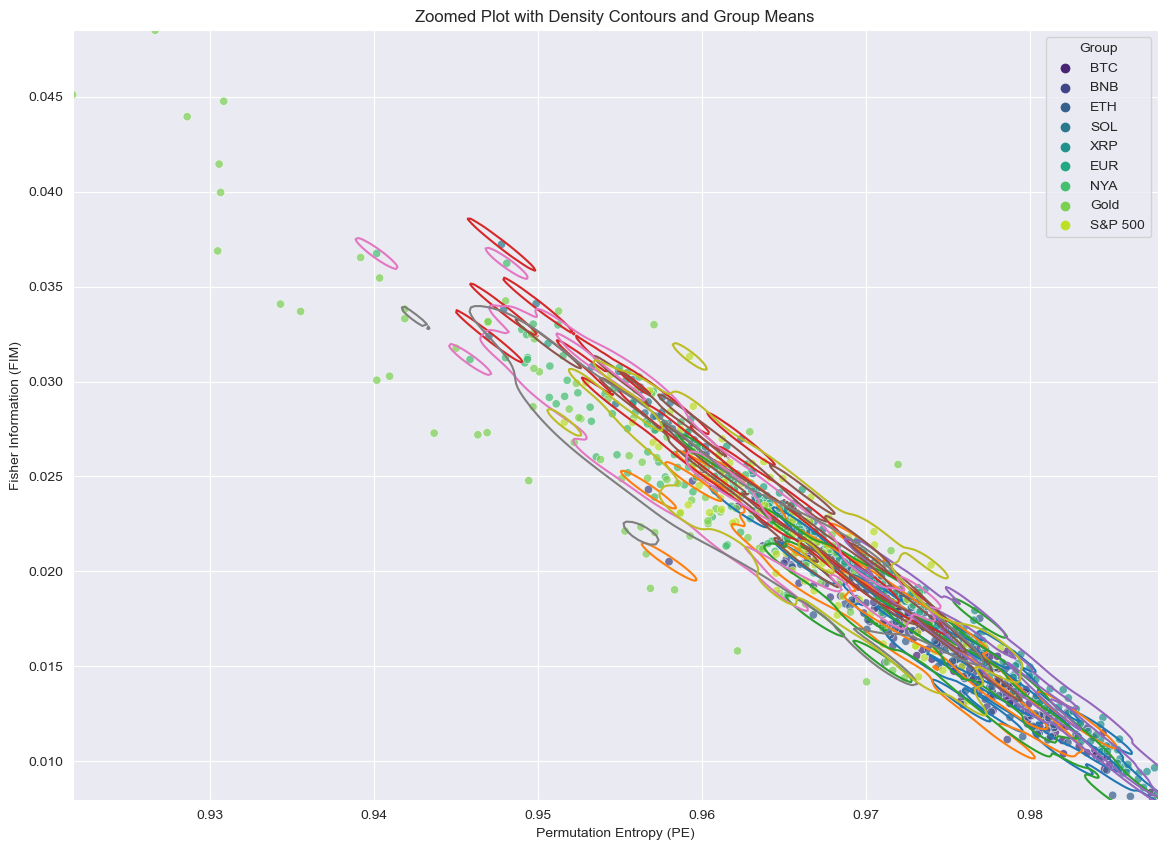

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
from mfn.entropy import MFN

data = []

# Assuming df is already defined as per your code
for f, name in csv_files:
    reader = CryptoCsvReader(f'data/{f}')
    time_series = reader.read()
    value_dict = MFN(
        time_series,
        b=10,
        B=.1,
        size=100,
        dx=3
    )
    pe = value_dict['permutation entropy']
    fim = value_dict['fisher information']

    for p, f_i in zip(pe, fim):
        data.append({'PE': p, 'FIM': f_i, 'group': name})
        
df = pd.DataFrame(data)

plt.figure(figsize=(14, 10))

# Density contours with adjusted bandwidth
sns.kdeplot(data=df, x='PE', y='FIM', hue='group', color='k', levels=3, bw_adjust=0.5)

# Points with increased size
sns.scatterplot(data=df, x='PE', y='FIM', hue='group', palette='viridis', alpha=0.7)

# Set axis limits to zoom in (adjust these limits as needed)
plt.xlim(df['PE'].min(), df['PE'].max())
plt.ylim(df['FIM'].min(), df['FIM'].max())

plt.title('Zoomed Plot with Density Contours and Group Means')
plt.xlabel('Permutation Entropy (PE)')
plt.ylabel('Fisher Information (FIM)')
plt.legend(title='Group')
plt.show()


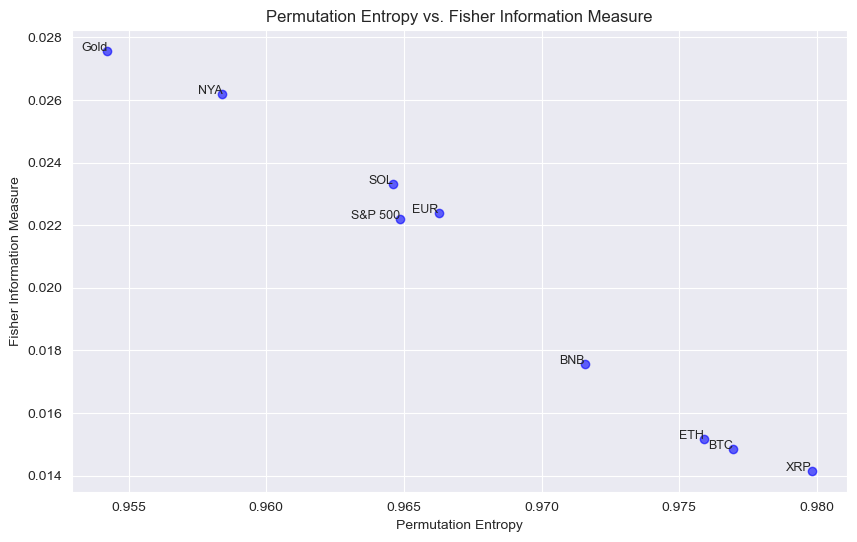

In [7]:


from mfn.entropy import MFN

means = []

for f, name in csv_files:
    reader = CryptoCsvReader(f'data/{f}')
    time_series = reader.read()
    value_dict = MFN(
        time_series,
        b=10,
        B=.1,
        size=100,
        dx=3
    )
    pe = np.mean(value_dict['permutation entropy'])
    fim = np.mean(value_dict['fisher information'])
    p = (pe, fim)
    means.append((p, name))

x = [point[0] for point, _ in means]  # Permutation Entropy
y = [point[1] for point, _ in means]  # Fisher Information Measure
labels = [name for _, name in means]  # Labels

# Plotting the points
plt.figure(figsize=(10, 6))
plt.scatter(x, y, color='blue', alpha=0.6)

# Adding labels to the points
for i, label in enumerate(labels):
    plt.text(x[i], y[i], label, fontsize=9, ha='right')

# Setting the axis labels and title
plt.xlabel('Permutation Entropy')
plt.ylabel('Fisher Information Measure')
plt.title('Permutation Entropy vs. Fisher Information Measure')
plt.grid(True)
plt.show()

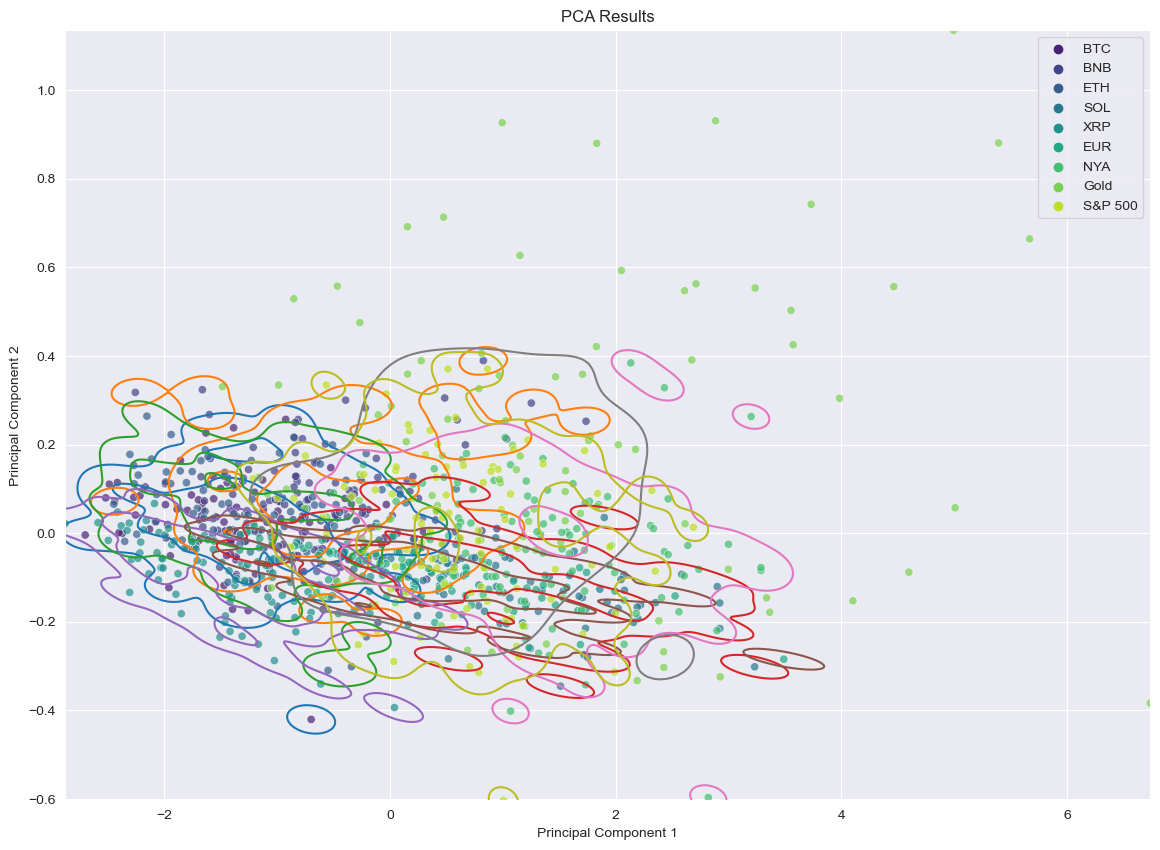

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from mfn.entropy import MFN

# Assuming csv_files is a list of tuples (filename, group_name)
data = []

# Process each CSV file
for f, name in csv_files:
    reader = CryptoCsvReader(f'data/{f}')
    time_series = reader.read()
    value_dict = MFN(
        time_series,
        b=10,
        B=.1,
        size=100,
        dx=3
    )
    pe = value_dict['permutation entropy']
    fim = value_dict['fisher information']

    for p, f_i in zip(pe, fim):
        data.append({'PE': p, 'FIM': f_i, 'group': name})

# Create DataFrame from the collected data
df = pd.DataFrame(data)

# Standardize the data (mean=0, variance=1)
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df[['PE', 'FIM']])

# Apply PCA to reduce the data to 2 dimensions
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_data)

# Create a new DataFrame for PCA results
pca_df = pd.DataFrame(pca_result, columns=['PC1', 'PC2'])
pca_df['group'] = df['group']

# Plot PCA results
plt.figure(figsize=(14, 10))

# Contour plot of PE and FIM
sns.kdeplot(data=pca_df, x='PC1', y='PC2', hue='group', levels=3, bw_adjust=0.5)

# Scatter plot of PCA results
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='group', palette='viridis', alpha=0.7)

# Set axis limits
plt.xlim(pca_df['PC1'].min(), pca_df['PC1'].max())
plt.ylim(pca_df['PC2'].min(), pca_df['PC2'].max())

plt.title('PCA Results')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title=False)
plt.show()
